# Importing important packages:

In [1]:
# Based on Pytorch tutorial for transfer learning
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
%matplotlib inline

#### Let's define the data transformations and creates PyTorch dataloaders for training and validation datasets. 

#### The data_transforms dictionary contains two keys, 'train' and 'validation', each of which has a list of transformations to be applied to the images. The 'train' transformations include resizing the image to 256x256, cropping it to 224x224 at the center, random horizontal flipping, color jittering, random affine transformations, random posterization, Gaussian blurring, and converting the image to a PyTorch tensor. Finally, the image is normalized using the mean and standard deviation of the ImageNet dataset. 

#### The 'validation' transformations are similar to the 'train' transformations but do not include any data augmentation techniques such as flipping or jittering.

#### The image datasets are then created using the `datasets.ImageFolder()` function, which reads images from the `data_dir` directory and applies the transformations specified in the data_transforms dictionary. The dataloaders are created using the `torch.utils.data.DataLoader()` function, which takes the image datasets and specifies a batch size of 6, shuffling the training data, and using 2 worker threads to load the data.

#### The `dataset_sizes` dictionary stores the number of images in each dataset, while the `class_names` list contains the names of the classes in the training dataset. Finally, the code checks whether a GPU is available and sets the device accordingly.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply(torch.nn.ModuleList([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1,0.1,0.1,0.1),
        transforms.RandomAffine(5)]), p=0.5),
        transforms.RandomPosterize(bits=2),
        transforms.GaussianBlur(kernel_size=5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download dataset for candidate testing from https://download.pytorch.org/tutorial/hymenoptera_data.zip
data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets['train'].classes

['bowriding',
 'cabincruiser',
 'commercial',
 'enforcement',
 'halfcab',
 'humanpowered',
 'open']

In [5]:
device

device(type='cpu')

#### Now, let's define a function imshow that takes a tensor (inp) and an optional title as inputs. The function first transposes the tensor from (C, H, W) to (H, W, C) format. It then normalizes the tensor values using the mean and standard deviation of the ImageNet dataset, as specified in the mean and std variables. The normalized tensor values are clipped to fall within the range [0, 1], and the resulting tensor is plotted as an image using Matplotlib. If a title is provided, it is added to the plot.

#### The function is then called with a batch of training data (inputs) and their corresponding classes (classes). The make_grid function from the torchvision.utils module is used to create a grid of images from the batch, which is passed to imshow. The title argument to imshow is set to a list of class names corresponding to the classes in the batch, obtained from class_names. The resulting image is displayed using Matplotlib's imshow function.

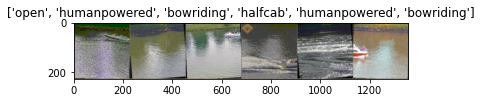

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### And let's define a `train_model` function that takes a pre-trained neural network model, a loss function, an optimizer, a learning rate scheduler, and hyperparameters such as the number of epochs and patience for early stopping as input. It then trains the model on the given dataset using the specified hyperparameters and returns the best performing model based on validation accuracy.

#### The function begins by initializing some variables to keep track of the best model weights, the best accuracy, and the number of epochs since the last best accuracy. It then iterates over the specified number of epochs and, for each epoch, trains the model on the training data and evaluates it on the validation data.

#### During each epoch, the function goes through both the `train` and `validation` phases, where the model is set to `train` mode for the former and `eval` mode for the latter. For each phase, the function goes through the data using the `DataLoader` object and calculates the loss and accuracy of the model on the batch. The function also uses the optimizer to update the model's parameters during the training phase. The accuracy is calculated by comparing the predicted labels to the ground truth labels.

#### After each epoch, the function checks if the validation accuracy has improved since the last epoch, and if so, it updates the variables for the best accuracy, the best epoch, and the best model weights. If the validation accuracy has not improved for `patience` epochs, the function stops training early and returns the best performing model. 

#### If the training completes all epochs without reaching the early stopping condition, the function returns the model with the best accuracy based on the validation set.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    epochs_since_best = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                    print('-',end='')
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Check if validation accuracy has improved
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
                epochs_since_best = 0
            elif phase == 'validation':
                epochs_since_best += 1

            # Early stopping
            if epochs_since_best == patience:
                print(f"No improvement for {patience} epochs. Training stopped.")
                time_elapsed = time.time() - since
                print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                print(f'Best val Acc: {best_acc:4f}')
                # load best model weights
                model.load_state_dict(best_model_wts)
                return model

        if epoch - best_epoch > patience:
            print(f"No improvement for {patience} epochs. Training stopped.")
            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Acc: {best_acc:4f}')
            # load best model weights
            model.load_state_dict(best_model_wts)
            return model

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### Now let's jump to a `visualize_model` function that takes in a PyTorch model and an optional argument `num_images` that specifies how many images to visualize. The purpose of this function is to display a grid of images with their predicted class labels generated by the model.

#### The function first sets the model to evaluation mode using `model.eval()` and saves the current training state in a variable `was_training`. It then initializes a figure object using Matplotlib and starts a loop over batches of data from the validation set. For each batch, the inputs and labels are loaded onto the appropriate device (CPU or GPU) using `inputs = inputs.to(device)` and `labels = labels.to(device)`.

#### The model is then run on the inputs using `outputs = model(inputs)`. The predicted class labels are obtained by taking the index of the maximum value of the output tensor along the second dimension using `_, preds = torch.max(outputs, 1)`.

#### For each image in the batch, the function creates a subplot with the predicted class label as the title using `ax.set_title(f'predicted: {class_names[preds[j]]}')`. The `imshow` function from Matplotlib is used to display the image using `imshow(inputs.cpu().data[j])`.

#### The function keeps track of the number of images displayed so far using the `images_so_far` variable, and terminates the loop once `num_images` images have been displayed. It then restores the original training state of the model using `model.train(mode=was_training)`. 

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Now let's set up a fine-tuning transfer learning approach to train a ResNet-34 model for a binary classification problem.

#### First, the pre-trained ResNet-34 model from the `torchvision` library is loaded with its pre-trained weights by setting `pretrained=True`. This pre-trained model is then modified by replacing its fully connected layer with a new one that has 2 output neurons, corresponding to the two classes in the binary classification problem. This new fully connected layer is initialized with random weights.

#### The `model_ft` is then moved to the `device` specified earlier. The `criterion` is set to the cross-entropy loss, which is a commonly used loss function for classification problems.

#### The `optimizer_ft` is set to AdamW with a learning rate of `3e-4`. AdamW is a variant of the Adam optimizer that employs weight decay regularization, which helps prevent overfitting.

#### Finally, the `exp_lr_scheduler` is set to a step learning rate scheduler, which reduces the learning rate by a factor of `0.1` every `7` epochs. This helps the optimizer to converge faster to the optimal weights and improve the accuracy of the model.

In [9]:
model_ft = models.resnet34(pretrained=True) # ~97% accuracy

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LAPTOP WORLD\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### The next cell will print any picture that is corrupted, uncomment it and run it if training the model got some error while reading any pictures

In [10]:
# try:
#     for phase in ['train', 'validation']:
#         for inputs, labels in dataloaders[phase]:
#             pass
# except Exception as e:
#     print(e)

# Model Training:

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,1)

Epoch 0/0
----------------------------------
train Loss: 0.9677 Acc: 0.6950
---------
validation Loss: 2.3728 Acc: 0.6400
Training complete in 1m 2s
Best val Acc: 0.640000


#### As we can see, the model got a val accuracy of 97.24%

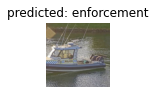

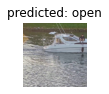

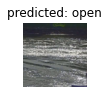

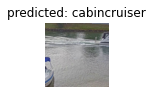

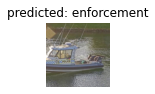

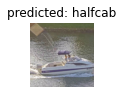

In [12]:
visualize_model(model_ft)

## Model Saving:

In [13]:
torch.save(model_ft.state_dict(), 'models/model.pt')